In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import os
import datetime
import time

In [2]:
days = 365
now = int(time.time())
start = now - 86400 * days
end = now

In [3]:
REQUIRED_CAPACITY = 1
SERVER_CAPACITY = 1
SERVER_RENT_COST = 5e3 / (5 * 365 * 24)
SERVER_POWER = 1e-3

In [4]:
def server_num(auslastung):
    return REQUIRED_CAPACITY / SERVER_CAPACITY / auslastung

def server_base_price(auslastung):
    return SERVER_RENT_COST * server_num(auslastung)

def server_duty_price(auslastung, price_per_mwh):
    return SERVER_POWER * price_per_mwh * server_num(auslastung)

def server_total_price(auslastung, price_per_mwh):
    return server_base_price(auslastung) + server_duty_price(auslastung, price_per_mwh)

In [5]:
fetch = False

if fetch or not os.path.exists("price.json"):
    price = "https://api.energy-charts.info/price?country=de&start=" + str(start) + "&end=" + str(now)
    response = requests.get(price)
    if response.status_code == 200:
        price_data = response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
    with open("price.json", "w") as f:
        json.dump(response.json(), f, indent=4)
else:
    with open("price.json", "r") as f:
        price_data = json.load(f)


In [6]:
timestamps = [pt for pt in price_data['unix_seconds']]
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
price_data = [pt for pt in price_data['price']]
probe_price = np.linspace(0, max(price_data), 100)

In [7]:
auslastung = []
price_sum = []
time_delta = timestamps[len(timestamps) - 1] - timestamps[0]

for probe in probe_price:
    t_auslastung = 0
    price_times_dt = 0
    for i in range(1, len(price_data) - 1):
        if price_data[i] <= probe:
            dt = ((timestamps[i+1] - timestamps[i]) + (timestamps[i] - timestamps[i-1])) / 2
            t_auslastung += dt
            price_times_dt += dt * price_data[i]
    auslastung.append(t_auslastung / time_delta)
    price_sum.append(price_times_dt / t_auslastung)

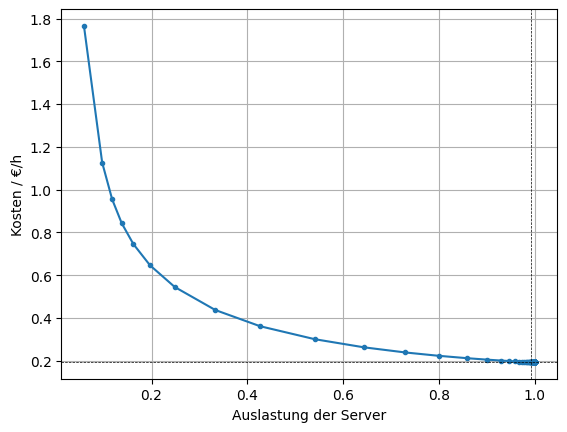

Anteil Server: 100.828825%
Auslastung der Server: 99.18%
Minimale Kosten pro Server: 0.20 €/h
Ersparnis ggü. Vollauslastung: 0.58%


In [8]:
lim = 0
price_list = server_total_price(np.array(auslastung[lim:]), np.array(price_sum[lim:]))
min_price = min(price_list)
min_auslastung = auslastung[lim + np.argmin(price_list)]
max_price = probe_price[lim + np.argmin(price_list)]
#plt.ylim(0, max(price_list) * 1.1)
plt.plot(auslastung[lim:], price_list, ".-", label="Total price")
plt.axvline(min_auslastung, color='black', linestyle='--', label="Minimum", linewidth=0.5)
plt.axhline(min_price, color='black', linestyle='--', linewidth=0.5)
plt.xlabel("Auslastung der Server")
plt.ylabel("Kosten / €/h")
plt.grid(visible=True, which='both', axis='both')
plt.show()

print(f'Anteil Server: {server_num(min_auslastung):.6%}\nAuslastung der Server: {min_auslastung:.2%}\nMinimale Kosten pro Server: {min_price:.2f} €/h\nErsparnis ggü. Vollauslastung: {1 - min_price / server_total_price(1, price_sum[-1]):.2%}')

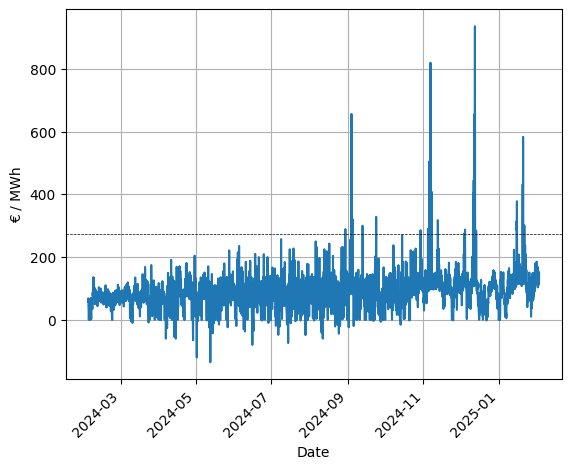

In [9]:
plt.xlabel("Date")
plt.ylabel("€ / MWh")
plt.grid(visible=True, which='both', axis='both')
plt.xticks(rotation=45, ha='right')
plt.plot(dates, price_data)
plt.axhline(max_price, color='black', linestyle='--', linewidth=0.5)
plt.show()

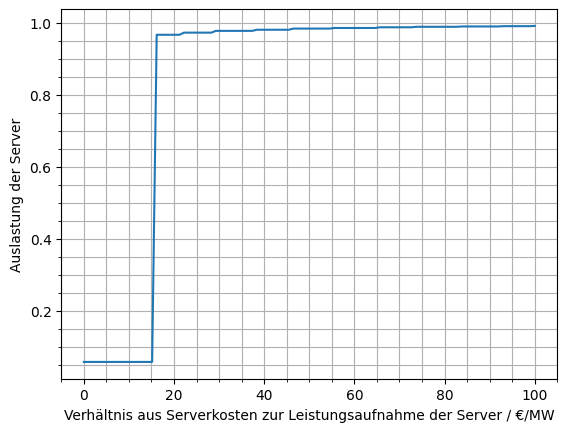

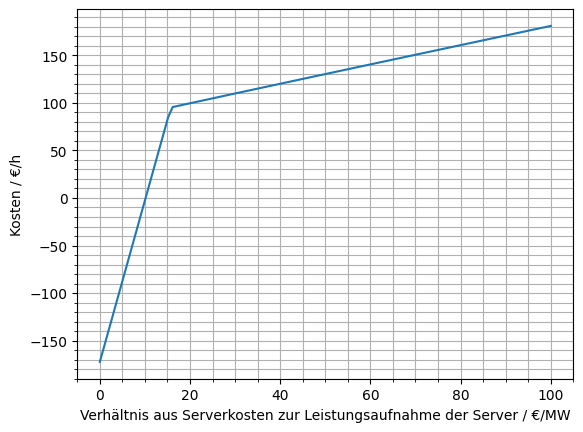

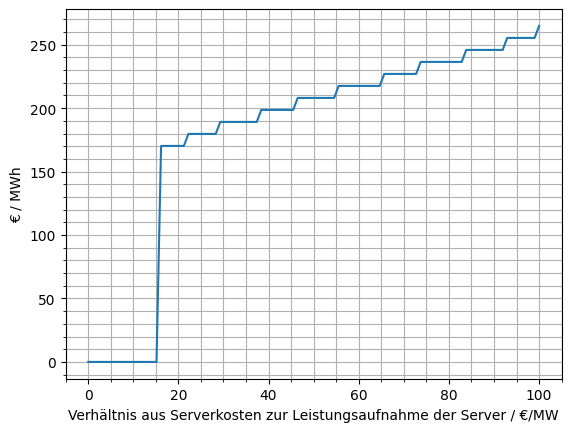

In [10]:
ratio = np.linspace(0, 100, 100)

min_price = []
min_auslastung = []
max_price = []

def server_total_price_variable(auslastung, price_per_mwh, cost, power):
    return cost * REQUIRED_CAPACITY / SERVER_CAPACITY / auslastung + power * price_per_mwh * REQUIRED_CAPACITY / SERVER_CAPACITY / auslastung

for r in ratio:
    auslastung = []
    price_sum = []
    time_delta = timestamps[len(timestamps) - 1] - timestamps[0]

    for probe in probe_price:
        t_auslastung = 0
        price_times_dt = 0
        for i in range(1, len(price_data) - 1):
            if price_data[i] <= probe:
                dt = ((timestamps[i+1] - timestamps[i]) + (timestamps[i] - timestamps[i-1])) / 2
                t_auslastung += dt
                price_times_dt += dt * price_data[i]
        auslastung.append(t_auslastung / time_delta)
        price_sum.append(price_times_dt / t_auslastung)
    
    price_list = server_total_price_variable(np.array(auslastung[lim:]), np.array(price_sum[lim:]), r, 1)
    min_price.append(min(price_list))
    min_auslastung.append(auslastung[lim + np.argmin(price_list)])
    max_price.append(probe_price[lim + np.argmin(price_list)])

plt.plot(ratio, min_auslastung, label="Minimale Kosten")
plt.xlabel("Verhältnis aus Serverkosten zur Leistungsaufnahme der Server / €/MW")
plt.ylabel("Auslastung der Server")
plt.grid(visible=True, which='both', axis='both')
plt.minorticks_on()
plt.show()

plt.plot(ratio, min_price, label="Minimale Kosten")
plt.xlabel("Verhältnis aus Serverkosten zur Leistungsaufnahme der Server / €/MW")
plt.ylabel("Kosten / €/h")
plt.grid(visible=True, which='both', axis='both')
plt.minorticks_on()
plt.show()

plt.plot(ratio, max_price, label="Preisgrenze")
plt.xlabel("Verhältnis aus Serverkosten zur Leistungsaufnahme der Server / €/MW")
plt.ylabel("€ / MWh")
plt.grid(visible=True, which='both', axis='both')
plt.minorticks_on()
plt.show()

TODO:
- Preisvorhersagen generieren
- Auslastung der Server für die Vorhersagen darstellen
- Leerlaufleistungsaufnahme
- CO2 von Hardware und Strom -> CO2 Minimum
- Netzentgelte (sonst 15 ct)